# Sample Based Interior/Edge Segmentation for 2D Data

---

Classifies each pixel as either Cell Edge, Cell Interior, or Background.

There are 2 different Cell Edge classes (Cell-Cell Boundary and Cell-Background Boundary)

In [1]:
import os
import errno
import datetime

import numpy as np

import deepcell

Using TensorFlow backend.


### Load the Training Data

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

X.shape: (6208, 216, 256, 1)
y.shape: (6208, 216, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

### Set up training parameters

In [5]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

n_epoch = 1  # Number of training epochs
test_size = .10  # % of data saved as test
norm_method = 'median'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# Sample mode settings
batch_size = 64  # number of images per batch (should be 2 ^ n)
win = (receptive_field - 1) // 2  # sample window size
balance_classes = True  # sample each class equally
max_class_samples = 1e6  # max number of samples per class.

# Transformation settings
transform = 'deepcell'
dilation_radius = 1  # change dilation radius for edge dilation
n_features = 4  # (cell-background edge, cell-cell edge, cell interior, background)

### First, create a foreground/background separation model

#### Instantiate the fgbg model

In [6]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_2D(
    receptive_field=receptive_field,
    n_features=2)

#### Train the fgbg model

In [7]:
from deepcell.training import train_model_sample

fgbg_model = train_model_sample(
    model=fgbg_model,
    dataset=DATA_FILE,  # full path to npz file
    expt='sample_fgbg',
    test_size=test_size,
    optimizer=optimizer,
    window_size=(win, win),
    batch_size=batch_size,
    transform='fgbg',
    n_epoch=n_epoch,
    balance_classes=balance_classes,
    max_class_samples=max_class_samples,
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2))

X_train shape: (6984, 216, 256, 1)
y_train shape: (6984, 216, 256, 1)
X_test shape: (776, 216, 256, 1)
y_test shape: (776, 216, 256, 1)
Output Shape: (None, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/1
25982/30265 [========================>.....] - ETA: 2:08 - loss: 0.0769 - acc: 0.9752

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Next, Create a model for the edge/interior segementation

#### Instantiate the distance transform model

In [8]:
from deepcell import model_zoo

sample_model = model_zoo.bn_feature_net_2D(
    n_features=n_features,  
    norm_method=norm_method,
    receptive_field=receptive_field,
    n_channels=X_train.shape[-1])

#### Train the model

In [9]:
from deepcell.training import train_model_sample

sample_model = train_model_sample(
    model=sample_model,
    dataset=DATA_FILE,  # full path to npz file
    expt='sample',
    transform=transform,
    dilation_radius=dilation_radius,
    optimizer=optimizer,
    batch_size=batch_size,
    test_size=test_size,
    window_size=(win, win),
    balance_classes=balance_classes,
    max_class_samples=max_class_samples,
    n_epoch=n_epoch,
    model_dir=MODEL_DIR,
    log_dir=LOG_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=0)

X_train shape: (6984, 216, 256, 1)
y_train shape: (6984, 216, 256, 1)
X_test shape: (776, 216, 256, 1)
y_test shape: (776, 216, 256, 1)
Output Shape: (None, 4)
Number of Classes: 4
Training on 1 GPUs
Epoch 1/1
 6167/38970 [===>..........................] - ETA: 15:33 - loss: 0.3235 - acc: 0.8416

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



18623/38970 [=============>................] - ETA: 9:27 - loss: 0.2999 - acc: 0.8498

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



31157/38970 [======================>.......] - ETA: 3:37 - loss: 0.2917 - acc: 0.8528

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



38968/38970 [============================>.] - ETA: 0s - loss: 0.2885 - acc: 0.8540
Epoch 00001: val_loss improved from inf to 0.25221, saving model to /data/models/2018-12-14_HeLa_S3_sample.h5
38970/38970 [==============================] - 1400s 36ms/step - loss: 0.2885 - acc: 0.8540 - val_loss: 0.2522 - val_acc: 0.8776


### Run the model

The model was trained on small samples of data of shape `(receptive_field, receptive_field)`.
in order to process full-sized images, the trained weights will be saved and loaded into a new model with `dilated=True` and proper `input_shape`.

#### Save weights of trained models

In [11]:
# Save the model weights to reload a dilated model

fgbg_weights_file = os.path.join(MODEL_DIR, '{}_{}_fgbg_sample.h5'.format(
    datetime.datetime.now().strftime('%Y-%m-%d'),
    os.path.splitext(os.path.basename(DATA_FILE))[0]
))
fgbg_model.save_weights(fgbg_weights_file)

sample_weights_file = os.path.join(MODEL_DIR, '{}_{}_{}.h5'.format(
    datetime.datetime.now().strftime('%Y-%m-%d'),
    os.path.splitext(os.path.basename(DATA_FILE))[0],
    '{}_sample'.format(transform)
))
sample_model.save_weights(sample_weights_file)

#### Initialize dilated model and load the weights

In [12]:
from deepcell import model_zoo

# All training parameters should match except for the `input_shape` and `dilated=True`

run_fgbg_model = model_zoo.bn_feature_net_2D(
    receptive_field=receptive_field,
    dilated=True,
    n_features=2,
    input_shape=tuple(X_test.shape[1:]))
run_fgbg_model.load_weights(fgbg_weights_file)

run_sample_model = model_zoo.bn_feature_net_2D(
    dilated=True,
    n_features=n_features,
    norm_method=norm_method,
    receptive_field=receptive_field,
    input_shape=tuple(X_test.shape[1:]))
run_sample_model.load_weights(sample_weights_file)

#### Make predictions on test data

In [13]:
# With the trained model, make predictions on testing data
test_images = run_sample_model.predict(X_test)
test_images_fgbg = run_fgbg_model.predict(X_test)

print('model output shape:', test_images.shape)
print('fgbg mask shape:', test_images_fgbg.shape)

model output shape: (1552, 216, 256, 4)
fgbg mask shape: (1552, 216, 256, 2)


#### Post-processing

In [14]:
argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('argmax shape:', argmax_images.shape)

argmax shape: (1552, 216, 256, 1)


In [15]:
# threshold the foreground/background
# and remove back ground from transform
threshold = 0.9

fg_thresh = test_images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)

argmax_images_post_fgbg = argmax_images * fg_thresh

In [16]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1],
                                min_distance=15, 
                                exclude_border=False,
                                indices=False,
                                labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=-1)

### Plot the results

Image number: 1198


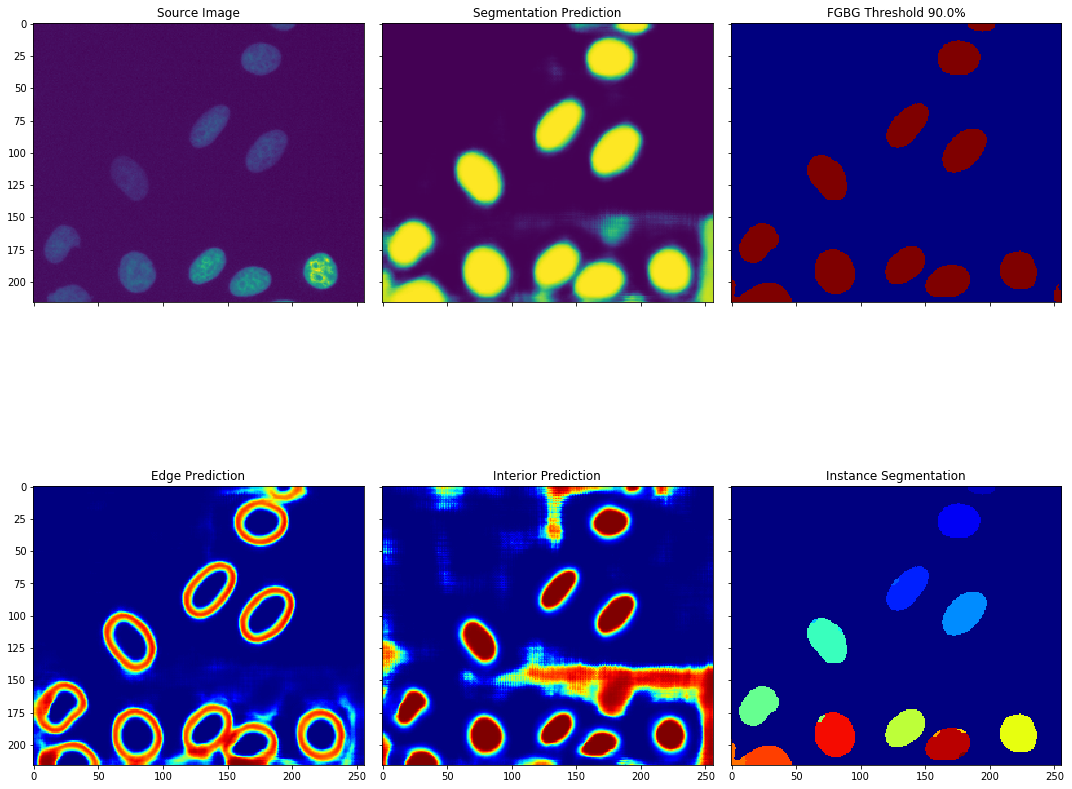

In [17]:
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(test_images[index, ..., 0] + test_images[index, ..., 1], cmap='jet')
ax[3].set_title('Edge Prediction')

ax[4].imshow(test_images[index, ..., 2], cmap='jet')
ax[4].set_title('Interior Prediction')

ax[5].imshow(watershed_images[index, ..., 0], cmap='jet')
ax[5].set_title('Instance Segmentation')

fig.tight_layout()
plt.show()